In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("..")

from llama_index.llms.openai import OpenAI
from src.local_models.embeddings import get_embed_model

from src.data_loader.load_files import load_data
from src.data_loader.chunking import chunk_docs_standalone

from src.data_loader.load_from_dir import rebuild_index

from src.nebula_graph.nebula_operations import show_hosts, add_hosts_if_not_available, show_spaces, init_nebula_cluster
from src.nebula_graph.text_2_graph import df_to_fig, extract_triplets, get_response_n_kg_rel_query, get_response_n_kg_rel_chat

#from llama_index.core import Document
import os, re, ast

from dotenv import load_dotenv

In [2]:
from llama_index.graph_stores.nebula import NebulaGraphStore
from llama_index.core import KnowledgeGraphIndex, VectorStoreIndex, SimpleDirectoryReader

from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import PromptTemplate


In [3]:
load_dotenv(override=True)

True

In [4]:
embed_model = get_embed_model(model_name=os.environ['embed_path'],  model_kwargs={'device': 'cpu'}, encode_kwargs = {'normalize_embeddings': True})
llm = OpenAI()

In [5]:
add_hosts_if_not_available()
space_name = "zelda"

init_nebula_cluster(space_name)

edge_types, rel_prop_names = ["relationship"], ["relationship"] # default, could be omit if create from an empty kg
tags = ["entity"]

graph_store = NebulaGraphStore(
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
)

In [6]:
#first-time build
documents = load_data(os.environ['data_path'])

In [18]:
len(documents)

38

In [19]:
kg_index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=10,
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
)

In [20]:
kg_index.storage_context.persist(persist_dir="../db_stores/kg_index")

In [ ]:
kg_index = rebuild_index('../db_stores/kg_index')

In [21]:
kg_rag_query_engine = kg_index.as_query_engine(
    include_text=True,
    retriever_mode="hybrid",
    response_mode="tree_summarize",
)


In [41]:
response = kg_rag_query_engine.query("告诉我关于劳鲁的一些事情")
#主角是谁
#告诉我关于主角的一些事情
#王国之泪的背景设定是什么
#告诉我关于劳鲁的一些事情


In [42]:
resp, kg_rel_texts = get_response_n_kg_rel_query(response)
kg_rel_texts

["['劳鲁', '是', '海拉鲁王国的首任国王']",
 "['劳鲁', '扮演', '教育和指导的角色']",
 "['劳鲁', '教授', '探索和战斗技巧']",
 "['劳鲁', '与', '六位贤者一起奋斗']",
 "['劳鲁', '是', '海底世界的守护者']",
 "['劳鲁', '被视为', '智慧的引导者']",
 "['劳鲁', '帮助', '玩家提升实力']",
 "['劳鲁', '是', '智慧引导者']",
 "['劳鲁', '是', '一位角色']",
 "['劳鲁', '为', '保护国民']"]

In [36]:
extracted_triplets = extract_triplets(kg_rel_texts)
extracted_triplets

,e1,r,e2
0,劳鲁,是,海拉鲁王国的首任国王
1,劳鲁,被视为,智慧的引导者
2,劳鲁,与,六位贤者一起奋斗
3,劳鲁,是,一位角色
4,劳鲁,帮助,玩家提升实力
5,劳鲁,扮演,教育和指导的角色
6,劳鲁,教授,探索和战斗技巧
7,劳鲁,为,保护国民
8,劳鲁,是,海底世界的守护者
9,劳鲁,是,智慧引导者


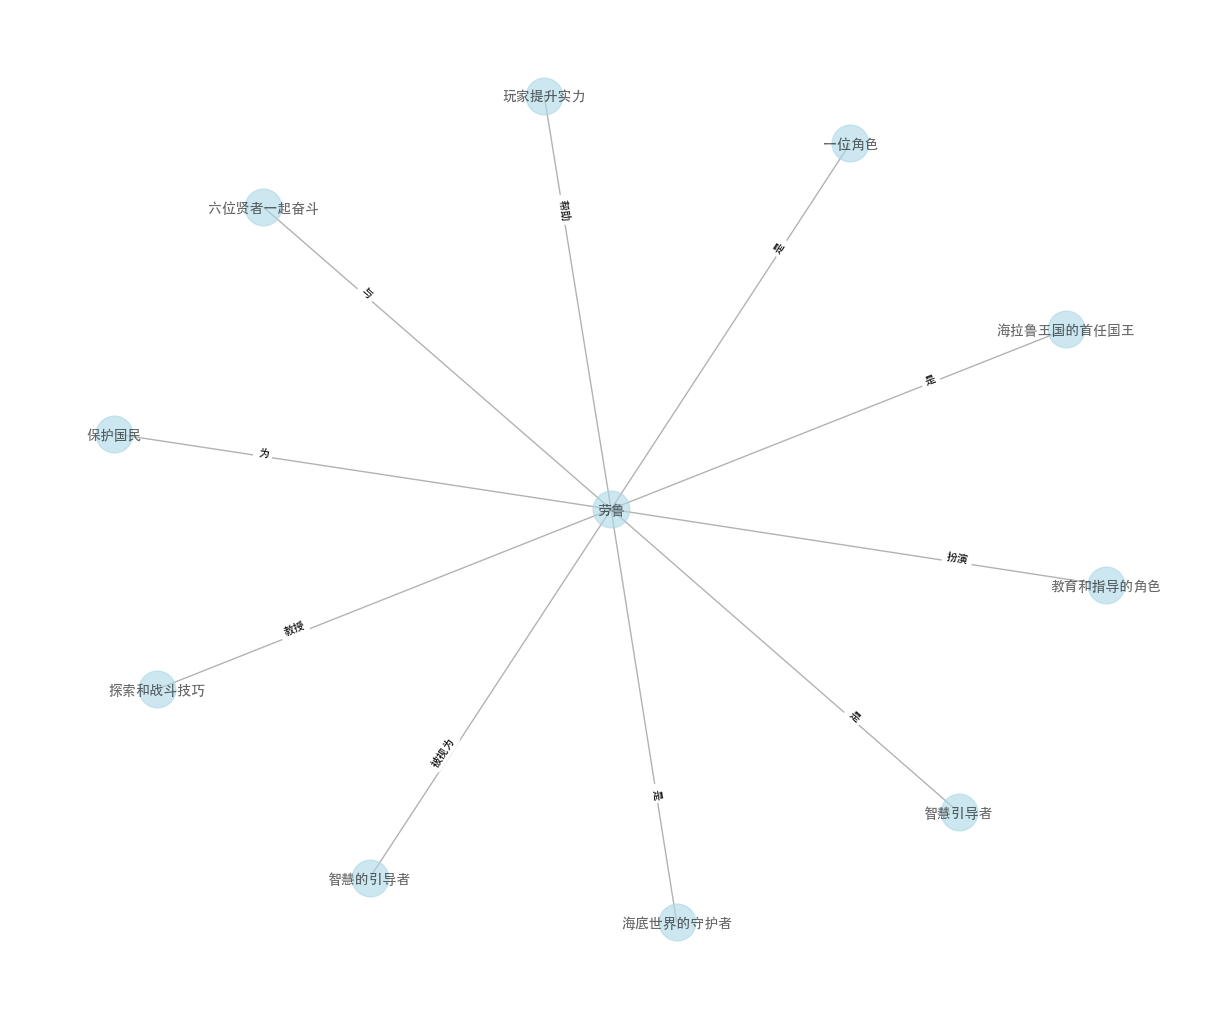

In [37]:
kg_fig = df_to_fig(extracted_triplets, show_fig=True)